In [1]:
''' imports '''

# plotting with matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from string_to_embedding import string_to_embedding, super_to_embedding

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
''' build 'image' dataset (shading maps as 2d array) as list '''
read_in = pd.read_csv('shading_series.csv', header=0, names=['Shading Map'], usecols=[1])
print(read_in)
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    a = np.pad(a, ((0,), (2,)))
    a = np.divide(a, 10)
    return a
l = [convert_to_array(s) for s in read_in['Shading Map']]

                                            Shading Map
0     [[ 5.38764783  4.00788436  1.37976347  0.59132...
1     [[ 3.95244216  3.02056555  0.          0.99614...
2     [[ 1.24570447  4.16666667  5.32646048  2.10481...
3     [[ 4.47183099  5.88028169  2.78169014  2.07746...
4     [[ 0.          3.26633166 10.          6.78391...
...                                                 ...
9995  [[ 1.70454545  4.62662338  5.56006494  3.57142...
9996  [[ 0.59618442  0.91414944  2.38473768  3.97456...
9997  [[ 0.15337423  0.84355828  2.07055215  2.41564...
9998  [[ 0.          0.73333333  5.53333333  5.86666...
9999  [[ 0.03787879  0.45454545  2.27272727  4.84848...

[10000 rows x 1 columns]


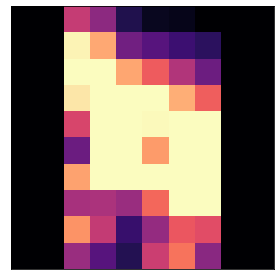

In [4]:
''' select cell image by label '''

_cell = l[0]

# diplay images
_w = 4; _h = 4; fig = plt.figure(figsize = (_w, _h))
ax = []; ax.append(fig.add_subplot(111))#; ax.append(fig.add_subplot(122))

ax[0].imshow(_cell, cmap = 'magma')

ax[0].set_xticks([]); ax[0].set_yticks([])

plt.tight_layout()
plt.show()


In [5]:
from torch.utils.data import Dataset

''' dataset components '''

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    

In [6]:
''' reshape, convert to tensors, init dataset '''

# init random with seed
#random.seed(252)

# inplace shuffle dataset (augmentations)
#random.shuffle(data)

# stack and reshape cell image dataset (n images, 1 channel, width, height)
#__data = np.stack(_data).reshape(len(_data),1,_data[0].shape[0],_data[0].shape[1])
#__data.shape

# list of tensors, reshaped with 1 channel
_data = [ torch.Tensor(_.reshape(1,_.shape[0],_.shape[1])) for _ in l ]

# initialise custom dataset from cell images
dataset = CustomDataset(_data, list(range(len(_data))))

In [7]:
list(_data[0].shape[1:])

[10, 10]

In [8]:
_data[0].shape

torch.Size([1, 10, 10])

In [9]:
''' use cuda else cpu for compute '''

# check available compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
''' define cnn vae model '''

class VAE(nn.Module):
    #def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=64):
    def __init__(self, imgChannels=1, fDim=8, kern=3, zDim=32, lDim=1024, imgShape = (10,10)):
        super(VAE, self).__init__()
        
        self.fDim = fDim
        self.imgShape = imgShape
        self.featureDim = 2*self.fDim*(self.imgShape[0])*(self.imgShape[1])#*4//kern
        
        #self.featureDim = _in - (kern-1)-1
        
        #self.featureDim = 2*self.fDim*20*20
        #print(self.featureDim)
        
        self.pad = (kern-1)//2

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, fDim, kern, padding = self.pad ) # (in_channels, out_channels, kernel)
        #self.encConv2 = nn.Conv2d(fDim, 2*fDim, kern, padding = 'same')
        self.encConv2 = nn.Conv2d(fDim, 2*fDim, kern, padding = self.pad )
        self.encFC1 = nn.Linear(lDim, zDim)
        self.encFC2 = nn.Linear(lDim, zDim)
        self.encFC3 = nn.Linear(self.featureDim, lDim) # large linear layer between layers 1 and 2
        self.relu = nn.ReLU(inplace=True)
        
        # 6 conv layers, 6 -> 16 -> 32 -> 64 -> 32 -> 16 ->(linear) -> ... -> 10,800
        
        # embedding dimensions are (10, 6, 10, 6, 3) 10,800 nodes or (60, 60, 3)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC2 = nn.Linear(zDim, lDim)
        self.decFC1 = nn.Linear(lDim, self.featureDim)
        self.decConv1 = nn.ConvTranspose2d(2*fDim, fDim, kern, padding = self.pad )
        self.decConv2 = nn.ConvTranspose2d(fDim, imgChannels, kern, padding = self.pad )

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        #print('enc ', x.shape)
        x = F.relu(self.encConv1(x))
        #print('conv1 ', x.shape)
        x = F.relu(self.encConv2(x))
        #print('conv2 ', x.shape)
        x = x.view(-1, self.featureDim)
        x = self.encFC3(x)
        x = self.relu(x)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input.
        x = F.relu(self.decFC2(z))
        x = F.relu(self.decFC1(x))
        #print('dec ', x.shape)
        x = x.view(-1, 2*self.fDim, self.imgShape[0], self.imgShape[1])
        #x = x.view(-1, 2*self.fDim, 10, 10)
        #print('decv ', x.shape)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [11]:
""" Initialize Hyperparameters """

# init hyper params
batch_size = 32 # 32-64 is advisable
learning_rate = 1e-3 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 


In [13]:
""" Create dataloaders to feed data into the neural network """

## note: better to split dataset into ~80:20 train:test, below simply entire dataset

# training dataset
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# test/validation dataset
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)


torch.Size([1, 10, 10])


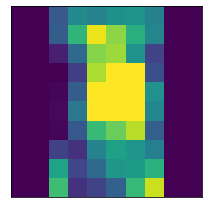

tensor(2618)


In [86]:
""" Check image dataset """
    
# get single random image batch from test dataset
for d in random.sample(list(test_loader), 1):

    # unpack image data, label from sample
    imgs, _ = d

    # push images to gpu
    imgs = imgs.to(device)

    print(imgs[0].shape)

    # get single image from gpu
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])

    plt.figure(figsize = (3,3))

    # plot input image
    plt.subplot(111)
    plt.imshow(np.squeeze(img))
    plt.xticks([]); plt.yticks([])


    plt.tight_layout()
    plt.show()

    print(_[0])

    break
        

In [87]:
""" Initialize the network """

# init vae model
#net = VAE().to(device)

# init model with specified hyperparams
#net = VAE(fDim=16, kern=(1), zDim=32, imgShape=(25,25)).to(device)
net = VAE().to(device)


In [88]:
""" Initialize the Adam optimizer """

# init adam optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


In [89]:
net.encConv1.bias.data

tensor([-0.3075, -0.2083, -0.0278,  0.0251, -0.1115,  0.0657,  0.3169, -0.2905])

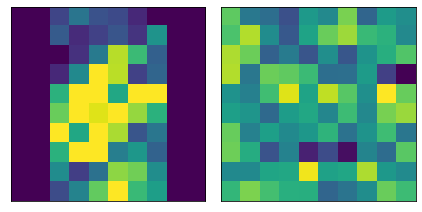

tensor(1449)


In [90]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

# set model eval state
net.eval()

# without compute gradients
with torch.no_grad():
    
    # get single random image batch from test dataset
    for d in random.sample(list(test_loader), 1):
        
        # unpack image data, label from sample
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        # get single image from gpu
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        
        plt.figure(figsize = (6,3))
        
        # plot input image
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.xticks([]); plt.yticks([])
        
        # compute output image
        out, mu, logVAR = net(imgs)
        
        # get output image from gpu, reshape
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        
        # plot output image
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.xticks([]); plt.yticks([])
        
        plt.tight_layout()
        plt.show()
        
        print(_[0])
        
        break
        

In [91]:
print(imgs)

tensor([[[[0.0000, 0.0000, 0.2081, 0.3901, 0.2503, 0.2243, 0.1138, 0.0033,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.2861, 0.1235, 0.1951, 0.2633, 0.1495, 0.5137,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.1430, 0.4064, 0.8908, 0.6827, 0.3056,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.1170, 0.4746, 1.0000, 0.8973, 0.1918, 0.3251,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.6437, 1.0000, 1.0000, 0.5982, 1.0000, 1.0000,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.7705, 1.0000, 0.9493, 1.0000, 0.8420, 0.6372,
           0.0000, 0.0000],
          [0.0000, 0.0000, 1.0000, 0.5949, 1.0000, 0.8713, 0.2633, 0.3934,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.6372, 1.0000, 1.0000, 0.4291, 0.5299, 0.3153,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.4844, 0.1853, 0.3739, 0.8290, 0.7835, 0.4909,
           0.0000, 0.0000],
          [0.0000, 0.0000, 0.2308, 0.4454, 0.7607, 1.0000, 0.6795, 0.5592

In [92]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

# set train state
net.train()

num_epochs = 100

# iterate over epochs
for epoch in range(num_epochs):
    
    # iterate over training dataset by batch
    for idx, d in enumerate(train_loader, 0):
        
        # unpack batch images and labels
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        #print('batch ',imgs.shape)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        #print('out ', out.shape)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs) + kl_divergence #TODO: de-weight the kl_divergence
        #loss = (optimised power value from labels - observed power)^2 for supervised model

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 0.3454967439174652
Epoch 1: Loss 0.3508634567260742
Epoch 2: Loss 0.37597084045410156
Epoch 3: Loss 0.35750797390937805
Epoch 4: Loss 0.36550983786582947
Epoch 5: Loss 0.35332709550857544
Epoch 6: Loss 0.34153908491134644
Epoch 7: Loss 0.3319317102432251
Epoch 8: Loss 0.349409282207489
Epoch 9: Loss 0.3609241843223572
Epoch 10: Loss 0.366657018661499
Epoch 11: Loss 0.3780399262905121
Epoch 12: Loss 0.35723185539245605
Epoch 13: Loss 0.34744930267333984
Epoch 14: Loss 0.3502640426158905
Epoch 15: Loss 0.3660466969013214
Epoch 16: Loss 0.354277640581131
Epoch 17: Loss 0.3504391312599182
Epoch 18: Loss 0.3610565960407257
Epoch 19: Loss 0.3668939769268036
Epoch 20: Loss 0.33947980403900146
Epoch 21: Loss 0.34979888796806335
Epoch 22: Loss 0.3578239679336548
Epoch 23: Loss 0.34364479780197144
Epoch 24: Loss 0.36902862787246704
Epoch 25: Loss 0.34927037358283997
Epoch 26: Loss 0.34972140192985535
Epoch 27: Loss 0.3599760830402374
Epoch 28: Loss 0.3489381968975067
Epoch 29: Loss

KeyboardInterrupt: 

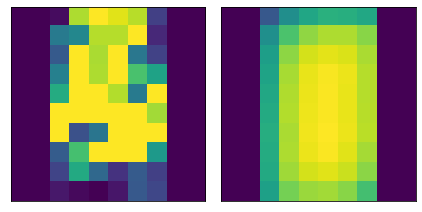

tensor(1469)


In [107]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

# set model eval state
net.eval()

# without compute gradients
with torch.no_grad():
    
    # get single random image batch from test dataset
    for d in random.sample(list(test_loader), 1):
        
        # unpack image data, label from sample
        imgs, _ = d
        
        # push images to gpu
        imgs = imgs.to(device)
        
        # get single image from gpu
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        
        plt.figure(figsize = (6,3))
        
        # plot input image
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.xticks([]); plt.yticks([])
        
        # compute output image
        out, mu, logVAR = net(imgs)
        
        # get output image from gpu, reshape
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        
        # plot output image
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.xticks([]); plt.yticks([])
        
        plt.tight_layout()
        plt.show()
        
        print(_[0])
        
        break
        

In [108]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'f{}-k{}-z{}-i{}-v{}.pth'.format(8,3,256,115,'01')

torch.save({
            #'epoch': epoch,
            #'model_state_dict': model.state_dict(),
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
}, _path)


In [19]:
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = '../data/model/cnn-vae-f8-k3-z256-i115-v01.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
net.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()